In [ ]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
Layer=keras.layers.Layer


# The time embedding layer takes the number of sequences and stores the data in order to find linear and periodic dependancies in the data. "Learns how the ball moves over time"
class Time2Vector(Layer): #Time embedding layer
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        self.weights_linear = self.add_weight(name='weight_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_linear = self.add_weight(name='bias_linear',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.weights_periodic = self.add_weight(name='weight_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                    shape=(int(self.seq_len),),
                                    initializer='uniform',
                                    trainable=True)

    def call(self, x):
        x = tf.math.reduce_mean(x[:,:,:], axis=-1) # Convert (batch, seq_len, 5) to (batch, seq_len)
        time_linear = self.weights_linear * x + self.bias_linear
        time_linear = tf.expand_dims(time_linear, axis=-1) # (batch, seq_len, 1)

        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # (batch, seq_len, 1)

        return tf.concat([time_linear, time_periodic], axis=-1) # (batch, seq_len, 2)

In [ ]:
## Building the architeture for the network.
#Singele attention layers are stacked to create multiattention, which are then stacked to create transformerencoders

class SingleAttention(Layer):
    def __init__(self, d_k, d_v):
        super(SingleAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v

    def build(self, input_shape):
        self.query = tf.keras.layers.Dense(self.d_k, input_shape=input_shape,kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
        self.key = tf.keras.layers.Dense(self.d_k, input_shape=input_shape,kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')
        self.value = tf.keras.layers.Dense(self.d_v, input_shape=input_shape,kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')

    def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
        q = self.query(inputs[0])
        k = self.key(inputs[1])
        attn_weights = tf.matmul(q, k, transpose_b=True)
        attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
        attn_weights = tf.nn.softmax(attn_weights, axis=-1)
        v = self.value(inputs[2])
        attn_out = tf.matmul(attn_weights, v)
        return attn_out

## MultiAttention layer takes several singleattention layers and
#n_heads is the hyperparameter that determines the number of parallel attention mechanisms that the model uses to attend to different parts of the input sequence.
class MultiAttention(Layer): #Multihead attention
  def __init__(self, d_k, d_v, n_heads,filt_dim):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.filt_dim=filt_dim
    self.attn_heads = list()

#MultiAttention layer using the SingleAttention layer.
#The SingleAttention layer takes the query, key, and value inputs and performs scaled dot-product attention on them.
# Number of heads are the number of singleAttention layers.
  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))
    self.linear = tf.keras.layers.Dense(self.filt_dim, input_shape=input_shape, kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear

## The transformerEncoder combines the muliAttentions, adds dropout to the model, normalizes the model and has 2 convolutional layers. aswell as a normalizing layer in the end.
class TransformerEncoder(Layer): #Combining everything into a Transformer encoder
  def __init__(self, d_k, d_v, n_heads, ff_dim,filt_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.filt_dim=filt_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads,self.filt_dim)
    self.attn_dropout = tf.keras.layers.Dropout(self.dropout_rate)
    self.attn_normalize = tf.keras.layers.LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = tf.keras.layers.Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    self.ff_conv1D_2 = tf.keras.layers.Conv1D(filters=self.filt_dim, kernel_size=1) #
    self.ff_dropout = tf.keras.layers.Dropout(self.dropout_rate)
    self.ff_normalize = tf.keras.layers.LayerNormalization(input_shape=input_shape, epsilon=1e-6)

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer


In [ ]:
!pip install -q deeptrack
import deeptrack as dt
import numpy as np

IMAGE_SIZE = 64
sequence_length = 10  # Number of frames per sequence
MIN_SIZE = 0.5e-6
MAX_SIZE = 1.5e-6
MAX_VEL = 10  # Maximum velocity. The higher the trickier!
MAX_PARTICLES = 3  # Max number of particles in each sequence. The higher the trickier!

# Defining properties of the particles
particle = dt.Sphere(
    intensity=lambda: 10 + 10 * np.random.rand(),
    radius=lambda: MIN_SIZE + np.random.rand() * (MAX_SIZE - MIN_SIZE),
    position=lambda: IMAGE_SIZE * np.random.rand(2),
    vel=lambda: MAX_VEL * np.random.rand(2),
    position_unit="pixel",
)

# Defining an update rule for the particle position
def get_position(previous_value, vel):

    newv = previous_value + vel
    for i in range(2):
        if newv[i] > 63:
            newv[i] = 63 - np.abs(newv[i] - 63)
            vel[i] = -vel[i]
        elif newv[i] < 0:
            newv[i] = np.abs(newv[i])
            vel[i] = -vel[i]
    return newv

particle = dt.Sequential(particle, position=get_position)

# Defining properties of the microscope
optics = dt.Fluorescence(
    NA=1,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
    magnification=10,
    resolution=(1e-6, 1e-6, 1e-6),
    wavelength=633e-9,
)

# Combining everything into a dataset.
# Note that the sequences are flipped in different directions, so that each unique sequence defines
# in fact 8 sequences flipped in different directions, to speed up data generation
sequential_images = dt.Sequence(
    optics(particle ** (lambda: 1 + np.random.randint(MAX_PARTICLES))),
    sequence_length=sequence_length,
)
dataset = sequential_images >> dt.FlipUD() >> dt.FlipDiagonal() >> dt.FlipLR()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

def generate_data(n_sequences):

    my_frames = []

    for _ in range(n_sequences):
        video=dataset.update().resolve()
        for frame in video:
            my_frames.append(frame)
    return tf.stack(my_frames)

n_sequences = 1000

#saved_data = generate_data(n_sequences)
#np.save('saved_data.npy', saved_data)

frame_data = np.load('/content/drive/MyDrive/saved_data.npy')

print(len(frame_data))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
10000


In [ ]:

neck_width = 512
print(neck_width)

## Autoencoder that takes an image of 64x64, bottleneck shape: 8x8, features: 1024,
# Decodes the image aswell

class Autoencoder(tf.keras.Model): #Creates the class Autoencoder that inherits from tf.keras.Model
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 1)),
            tf.keras.layers.Conv2D(2, (9, 9), padding='same', strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(4, (5, 5), padding='same', strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(8, (3, 3), padding='same', strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten()
        ])

          # Decoder
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(neck_width,)),
            tf.keras.layers.Reshape(target_shape=(8,8, 8)),
            tf.keras.layers.Conv2DTranspose(4, (3, 3), strides=(1,1 ), activation='relu', padding='same'),
            tf.keras.layers.Conv2DTranspose(2, (5, 5), strides=(2, 2), activation='relu', padding='same'),
            tf.keras.layers.Conv2DTranspose(2, (9, 9), strides=(4, 4), activation='linear', padding='same'),
            tf.keras.layers.Conv2D(1, (1, 1), activation='linear', padding='same')
        ])



    def call(self, x):
        encoded_image = self.encoder(x)
        decoded_image = self.decoder(encoded_image)
        return decoded_image

autoencoder = Autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.encoder.build(input_shape=(None, 64, 64, 1))
autoencoder.encoder.summary()

autoencoder.decoder.build(input_shape=(None, neck_width))
autoencoder.decoder.summary()

512
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 2)         164       
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 4)         204       
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 8)           296       
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
Total params: 664
Trainable params: 664
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (

In [ ]:
n_images = len(frame_data)
training_data_ratio = 0.9

data_cut = int(n_images * training_data_ratio)

train_data = frame_data[:data_cut]
validation_data = frame_data[data_cut:]
## Normalizing the data, otherwise the training is shit.
max_val = tf.reduce_max(tf.concat([train_data, validation_data], 0))
train_data /= max_val
validation_data /= max_val

print(train_data.shape)
print(len(train_data))
print(len(validation_data))

(9000, 64, 64, 1)
9000
1000


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            verbose=1,
                                            mode='min',
                                            restore_best_weights=True)
autoencoder.fit(train_data, train_data,
                 batch_size=32,
                 epochs=50,
                 shuffle=True,
                 validation_data=(validation_data, validation_data),
                 callbacks=[callback])

autoencoder.save('saved_weights')

Epoch 1/50
282/282 [==============================] - 6s 8ms/step - loss: 0.0032 - val_loss: 5.5349e-04
Epoch 2/50
282/282 [==============================] - 3s 10ms/step - loss: 4.4979e-04 - val_loss: 3.2645e-04
Epoch 3/50
282/282 [==============================] - 3s 12ms/step - loss: 3.2252e-04 - val_loss: 2.6699e-04
Epoch 4/50
282/282 [==============================] - 4s 13ms/step - loss: 2.7124e-04 - val_loss: 2.2552e-04
Epoch 5/50
282/282 [==============================] - 4s 14ms/step - loss: 2.3230e-04 - val_loss: 2.0139e-04
Epoch 6/50
282/282 [==============================] - 3s 10ms/step - loss: 2.1239e-04 - val_loss: 1.8556e-04
Epoch 7/50
282/282 [==============================] - 3s 11ms/step - loss: 2.0423e-04 - val_loss: 1.7800e-04
Epoch 8/50
282/282 [==============================] - 3s 10ms/step - loss: 1.9105e-04 - val_loss: 1.6931e-04
Epoch 9/50
282/282 [==============================] - 4s 15ms/step - loss: 1.8597e-04 - val_loss: 1.6592e-04
Epoch 10/50
282/282 [===

sequence plotted 90


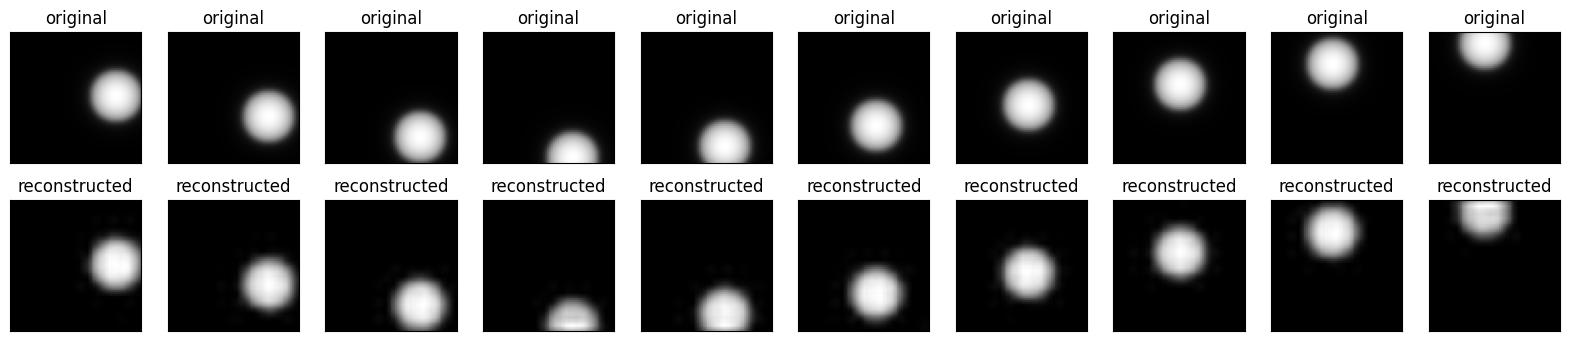

In [ ]:

autoencoder = tf.keras.models.load_model('saved_weights')

n = 10  # how many digits we will display
rand_sequence = np.random.randint(len(validation_data)/sequence_length)

seq_start = rand_sequence * sequence_length
print('sequence plotted',seq_start)

original = validation_data[seq_start : seq_start + sequence_length]
enc_image = autoencoder.encoder(original).numpy()
dec_image = autoencoder.decoder(enc_image).numpy()


plt.figure(figsize=(20, 4))
for i in range(10):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(tf.squeeze(original[i]))
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(tf.squeeze(dec_image[i]))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

# Part 2, Time embedding and prediction



In [ ]:

# The saved weights from the autoencoder are loaded.
autoencoder = tf.keras.models.load_model('saved_weights')

# Parameters
neck_width = 512

latent_dim = neck_width
d_k = neck_width
d_v = neck_width
n_heads = 60
ff_dim = neck_width
filt_dim = latent_dim+2

seq_len = 9 #Legth of input sequence (9 images)
autoencoder.trainable = False
autoencoder.encoder.trainable = False
autoencoder.decoder.trainable = False

def create_model(neck_width):
    filt_dim = neck_width + 2

    time_embedding = Time2Vector(seq_len) #This line initializes an instance of the Time2Vector class, which is used to generate a time embedding that is concatenated with the input sequence.
    attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim, filt_dim) #Initialize TransformerEncoder
    attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim, filt_dim) # The network consists of 3 attentionLayers
    attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim, filt_dim)

    in_seq = tf.keras.layers.Input(shape=(seq_len, neck_width)) #creates a Keras Input layer
    x = time_embedding(in_seq)  #This line generates the time embedding from the input sequence using the time_embedding layer.
    x = tf.keras.layers.Concatenate(axis=-1)([in_seq, x]) #This line concatenates the input sequence with the time embedding along the last axis.

    x = attn_layer1((x, x, x))
    x = attn_layer2((x, x, x))
    x = attn_layer3((x, x, x))

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Dense(latent_dim, activation='linear')(x)
    out = tf.keras.layers.LeakyReLU()(x)

    model = tf.keras.Model(inputs=in_seq, outputs=out)
    model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError())
    return model

model = create_model(neck_width)
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 9, 512)]     0           []                               
                                                                                                  
 time2_vector_1 (Time2Vector)   (None, 9, 2)         36          ['input_6[0][0]']                
                                                                                                  
 concatenate_1 (Concatenate)    (None, 9, 514)       0           ['input_6[0][0]',                
                                                                  'time2_vector_1[0][0]']         
                                                                                                  
 transformer_encoder_3 (Transfo  (None, 9, 514)      63782412    ['concatenate_1[0][0]',    

In [ ]:
compressed_train_images = autoencoder.encoder(train_data)
compressed_validation_images   = autoencoder.encoder(validation_data)

# split data into sequences
# Get the traing data sequences and validation sequences, also get the validation labels. (the last sequence from the )


comp_train_reshaped = tf.reshape(compressed_train_images,(900,sequence_length,neck_width))
comp_train_y_reshaped = tf.reshape(train_data,(900,sequence_length,64,64,1))


train_x = comp_train_reshaped[:,0:9,:] #training input (9 flattened frames neckwidth = 512)
train_label = comp_train_reshaped[:,9,:] #training label (1 flattened image neckwidh = 512)

print('Flattened input for the transformer:'+str(train_x.shape))
print("Training Label shape:"+str(train_label.shape))

comp_val_reshaped   = tf.reshape(compressed_validation_images,(100,sequence_length,neck_width))
comp_val_y_reshaped = tf.reshape(validation_data,(100,sequence_length, 64,64,1))

validation_x = comp_val_reshaped[:,0:9,:] #validation input
validation_label = comp_val_reshaped[:,9,:] #validation label

print("Flattened validation input:"+str(validation_x.shape))
print("Training label for validation:"+str(validation_label.shape))

Flattened input for the transformer:(900, 9, 512)
Training Label shape:(900, 512)
Flattened validation input:(100, 9, 512)
Training label for validation:(100, 512)


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            min_delta=0,
                                            patience=8,
                                            verbose=1,
                                            mode='auto',
                                            baseline=None,
                                            restore_best_weights=True)
model.fit(train_x, train_label,
                 batch_size=32,
                 epochs=100,
                 shuffle=True,
                 validation_data=(validation_x, validation_label),
                 callbacks=[callback])

model.save('transformer_encoder')

Epoch 1/100
29/29 [==============================] - 438s 4s/step - loss: 0.2057 - val_loss: 0.1522
Epoch 2/100
29/29 [==============================] - 90s 3s/step - loss: 0.1664 - val_loss: 0.1390
Epoch 3/100
29/29 [==============================] - 91s 3s/step - loss: 0.1620 - val_loss: 0.1382
Epoch 4/100
29/29 [==============================] - 91s 3s/step - loss: 0.1588 - val_loss: 0.1387
Epoch 5/100
29/29 [==============================] - 91s 3s/step - loss: 0.1562 - val_loss: 0.1412
Epoch 6/100
29/29 [==============================] - 93s 3s/step - loss: 0.1556 - val_loss: 0.1348
Epoch 7/100
29/29 [==============================] - 93s 3s/step - loss: 0.1499 - val_loss: 0.1324
Epoch 8/100
29/29 [==============================] - 92s 3s/step - loss: 0.1485 - val_loss: 0.1330
Epoch 9/100
29/29 [==============================] - 93s 3s/step - loss: 0.1469 - val_loss: 0.1316
Epoch 10/100
29/29 [==============================] - 92s 3s/step - loss: 0.1455 - val_loss: 0.1314
Epoch 11

In [ ]:
## This part of the code plots 10 different sequences. And compares the original 10th image to the predicted ones.


model = tf.keras.models.load_model('transformer_encoder')
autoencoder = tf.keras.models.load_model('saved_weights')

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    y_pred = model.predict(train_x[i:i+1])
    plt.subplot(2, n, i + 1)
    plt.title("Prediction")
    plt.imshow(tf.squeeze(autoencoder.decoder(y_pred)), cmap='gray')
    plt.subplot(2, n, i + 1 + n)
    a = tf.reshape(train_label[i],[1,512])
    plt.title("original")
    plt.imshow(tf.squeeze(autoencoder.decoder(a)), cmap='gray')

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    #print(val_x[i:i+1].shape)
    y_pred = model.predict(validation_x[i:i+1])
    #print(tf.squeeze(autoencoder.decoder(y_pred)).shape)
    plt.subplot(2, n, i + 1)
    plt.title("prediction")
    plt.imshow(tf.squeeze(autoencoder.decoder(y_pred)), cmap='gray')
    plt.subplot(2,n,i+1+n)
    a = tf.reshape(validation_label[i],[1,512])
    #print(autoencoder.decoder(a).shape)
    plt.title("original")
    plt.imshow(tf.squeeze(autoencoder.decoder(a)), cmap='gray')